# Strided Convolution Ablation Study
This notebook investigates the effect of using Strided Convolutions instead of Max Pooling for downsampling in the Intermediate Fusion model.
It compares:
1.  MaxPool2d: Standard max pooling layers.
2.  Strided Convolution: Convolutional layers with striding to learn downsampling.

The models are defined in `src/models.py` (`IntermediateFusionModel` vs `IntermediateFusionModelStrided`, `Embedder` vs `EmbedderStrided`).


## Setup
This is similar to `02_fusion_comparison.ipynb`. Check that for more detailed explainations.

In [1]:
from pathlib import Path
import sys
import os
try:
    from google.colab import drive
    drive.mount('/gdrive')
    print("Mounted Google Drive")
    DATA_DIR = Path('/gdrive/MyDrive/extended_assessments/Multimodal_Learning/data')
    sys.path.append(os.path.abspath('/gdrive/MyDrive/extended_assessments/Multimodal_Learning'))
except:
    print("Running locally")
    DATA_DIR = Path('../data')
    sys.path.append(os.path.abspath('../.'))
print(f"Using {DATA_DIR} as data source")

Running locally
Using ../data as data source


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import wandb

# Import dataset and models from src
import sys
import os
from src.datasets import CubesAndShperesDataset
from src.models import IntermediateFusionModel, IntermediateFusionModelStrided, LateFusionModel, LateFusionModelStrided
from src.training import train_model, evaluate_model, count_parameters

# Configuration
BATCH_SIZE = 32
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cpu


In [3]:
def set_seeds(seed=51):
    """
    Set seeds for complete reproducibility across all libraries and operations.

    Args:
        seed (int): Random seed value
    """
    # Set environment variables before other imports
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch GPU (all devices)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

        # CUDA deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # PyTorch deterministic algorithms (may impact performance)
    try:
        torch.use_deterministic_algorithms(True)
    except RuntimeError:
        # Some operations don't have deterministic implementations
        print("Warning: Some operations may not be deterministic")

    print(f"All random seeds set to {seed} for reproducibility")


set_seeds(51)

All random seeds set to 51 for reproducibility


## Datasets
The dataset class used is `CubesAndShperesDataset` from `src/datasets`. A noteworthy difference to the dataset from the NVIDIA Lab is, that I normalized the LiDAR values to be between 0 and 1 and not 0 and 50.

Since the CPU compute on google collab seems quite low and building the dataset took quite some time, I added the option to export the datasets and load them again, reducing the creation compute overhead. The first cell below tries to load the precomputed dataset from `dataset_precomputed.pkl`. The second cell below builds the datasets from scratch and the third cell below exports the created datasets into the `dataset_precomputed.pkl` file.

**If the precomputed file is available, only run the first of the three following cells!**
Otherwise this will take up to three hours!

The splitting logic is aligned with the NVIDIA Lab, where we take 10 Batches of 32 Samples per class for validation. This splitting is not very sophisticated, but I wanted to maintain alignment with the original experiments, since the final evaluation uses the Lab numbers as well.

In [ ]:
# load precomputed dataset
import pickle
with open("/gdrive/MyDrive/extended_assessments/Multimodal_Learning/notebooks/dataset_precomputed.pkl", "rb") as f:
    data = pickle.load(f)
train_indices = data["train_indices"]
val_indices = data["val_indices"]
train_dataset = data["train_dataset"]
val_dataset = data["val_dataset"]

In [4]:
# Build Datasets
full_dataset = CubesAndShperesDataset(DATA_DIR)

# Split into Train and Validation (No Test)
# Logic from 05_Assessment.ipynb: Last VALID_BATCHES * BATCH_SIZE are validation

total_len = len(full_dataset)
n_classes = 2
samples_per_class = total_len // n_classes

VALID_BATCHES = 10
valid_samples_per_class = VALID_BATCHES * BATCH_SIZE
train_samples_per_class = samples_per_class - valid_samples_per_class

train_indices = []
val_indices = []
for i in range(n_classes):
    start_idx = i * samples_per_class
    train_indices.extend(range(start_idx, start_idx + train_samples_per_class))
    val_indices.extend(range(start_idx + train_samples_per_class, start_idx + samples_per_class))

from torch.utils.data import Subset
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

Constructing Dataset for class cubes


Files for class: 100%|██████████| 9999/9999 [00:11<00:00, 864.00it/s]


Constructing Dataset for class spheres


Files for class: 100%|██████████| 10029/10029 [00:12<00:00, 831.25it/s]


In [ ]:
import pickle
with open("dataset_precomputed.pkl", "wb") as f:
    pickle.dump({
        "train_indices": train_indices,
        "val_indices": val_indices,
        "train_dataset": train_dataset,
        "val_dataset": val_dataset
    }, f)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total samples: {total_len}")
print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")

Total samples: 19998
Train size: 19358
Val size: 640


## Model Definitions

We use the `IntermediateFusionModel` and `IntermediateFusionModelStrided` from `src/models.py`.

The difference is, that while th original `IntermediateFusionModel` uses an untrainable `MaxPool2d` layer, we now have trainable `Conv2d` layers. This increases the prameter count and thus the compute and time required for training, but it allows for more sophisticated downsampling.

## Experiments

We iterate over a set of Hyperparameters again. We analyze the Embedder as part of the Late Fusion model. Further, I changed the Intermediate Fusion model architecture to support convolutional downsampling and tested that as well.

For these experiments, I only used the first 10 % of the training data, but the full validation set, since I had to run these experiments locally (due to Colab usage limitations :) )

In [6]:
results = {}

# Hyperparameters to test
learning_rates = [1e-4, 1e-5]
use_schedulers = [True, False]

# Define models to test
# Format: (Name, ID, ModelClass, InitArgs)
strategies = [
    ("Late Fusion", "late-fusion-maxpool", LateFusionModel, {}),
    ("Late Fusion Strided", "late-fusion-strided", LateFusionModelStrided, {}),
    ("MaxPool2d", "IF-mul-maxpool", IntermediateFusionModel, {'fusion_type': 'multiply'}),
    ("Strided Conv", "IF-mul-strided-conv", IntermediateFusionModelStrided, {'fusion_type': 'multiply'}),
]
best_val_acc = 0.0
best_model_info = None
for name, strategy_id, model_cls, model_kwargs in strategies:
    for lr in learning_rates:
        for use_sched in use_schedulers:
            sched_str = "cosine" if use_sched else "constant"
            run_name = f"{strategy_id}_lr{lr}_{sched_str}"

            print(f"\n=== Training {name} | LR: {lr} | Scheduler: {sched_str} ===")

            wandb.init(project="clip-extended-assessment", name=run_name, entity="jan-kubeler-hpi", config={
                "downsampling": strategy_id,
                "batch_size": BATCH_SIZE,
                "learning_rate": lr,
                "scheduler": sched_str,
                "epochs": EPOCHS
            })

            # Initialize model
            model = model_cls(**model_kwargs).to(DEVICE)
            model_params = count_parameters(model)

            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()
            scheduler = None
            if use_sched:
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

            # Train
            train_loss, val_loss, val_acc, train_time = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=EPOCHS, scheduler=scheduler, use_wandb=True, device=DEVICE)

            # Evaluate on Validation Set (since we don't have a separate test set)
            final_acc, _, _, _ = evaluate_model(model, val_loader, device=DEVICE)

            results[run_name] = {
                'Validation Loss': val_loss[-1],
                'Parameters': model_params,
                'Training Time (s)': train_time,
                'Final Accuracy': final_acc
            }

            print(f"Final Val Metrics: Acc={final_acc:.4f}")

            if final_acc > best_val_acc:
                best_val_acc = final_acc
                best_model_info = {
                    "name": name,
                    "strategy_id": strategy_id,
                    "model_cls": model_cls,
                    "model_kwargs": model_kwargs,
                    "learning_rate": lr,
                    "scheduler": sched_str,
                    "accuracy": final_acc,
                }
                torch.save(model.state_dict(), f"../checkpoints/best_stride_abl_model.pth")
                with open("../checkpoints/best_stride_abl_model_info.txt", "wb") as f:
                    f.write(str(best_model_info).encode())

            wandb.finish()


=== Training Late Fusion | LR: 0.0001 | Scheduler: cosine ===


wandb: Currently logged in as: jan-kubeler (gorillawatch) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10, LR: 0.000098, Train Loss: 0.0673, Val Loss: 0.6773, Val Acc: 0.5000
Epoch 2/10, LR: 0.000090, Train Loss: 0.0520, Val Loss: 0.2942, Val Acc: 0.9344
Epoch 3/10, LR: 0.000079, Train Loss: 0.0148, Val Loss: 0.0910, Val Acc: 0.9672
Epoch 4/10, LR: 0.000065, Train Loss: 0.0084, Val Loss: 0.0664, Val Acc: 0.9812
Epoch 5/10, LR: 0.000050, Train Loss: 0.0069, Val Loss: 0.0770, Val Acc: 0.9672
Epoch 6/10, LR: 0.000035, Train Loss: 0.0058, Val Loss: 0.0522, Val Acc: 0.9859
Epoch 7/10, LR: 0.000021, Train Loss: 0.0047, Val Loss: 0.0424, Val Acc: 0.9875
Epoch 8/10, LR: 0.000010, Train Loss: 0.0032, Val Loss: 0.0368, Val Acc: 0.9891
Epoch 9/10, LR: 0.000002, Train Loss: 0.0035, Val Loss: 0.0334, Val Acc: 0.9875
Epoch 10/10, LR: 0.000000, Train Loss: 0.0037, Val Loss: 0.0326, Val Acc: 0.9875
Final Val Metrics: Acc=0.9875


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▇▆▅▃▂▂▁▁
train_loss,█▆▂▂▁▁▁▁▁▁
val_acc,▁▇████████
val_loss,█▄▂▁▁▁▁▁▁▁
epoch,10
learning_rate,0
train_loss,0.00368
val_acc,0.9875
val_loss,0.03256



=== Training Late Fusion | LR: 0.0001 | Scheduler: constant ===


Epoch 1/10, LR: 0.000100, Train Loss: 0.0673, Val Loss: 0.6742, Val Acc: 0.6078
Epoch 2/10, LR: 0.000100, Train Loss: 0.0463, Val Loss: 0.2178, Val Acc: 0.9156
Epoch 3/10, LR: 0.000100, Train Loss: 0.0131, Val Loss: 0.1210, Val Acc: 0.9406
Epoch 4/10, LR: 0.000100, Train Loss: 0.0089, Val Loss: 0.1461, Val Acc: 0.9359
Epoch 5/10, LR: 0.000100, Train Loss: 0.0080, Val Loss: 0.0840, Val Acc: 0.9656
Epoch 6/10, LR: 0.000100, Train Loss: 0.0069, Val Loss: 0.0601, Val Acc: 0.9766
Epoch 7/10, LR: 0.000100, Train Loss: 0.0041, Val Loss: 0.0588, Val Acc: 0.9781
Epoch 8/10, LR: 0.000100, Train Loss: 0.0026, Val Loss: 0.0258, Val Acc: 0.9891
Epoch 9/10, LR: 0.000100, Train Loss: 0.0040, Val Loss: 0.0205, Val Acc: 0.9938
Epoch 10/10, LR: 0.000100, Train Loss: 0.0028, Val Loss: 0.0217, Val Acc: 0.9938
Final Val Metrics: Acc=0.9938


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▂▂▂▁▁▁▁▁
val_acc,▁▇▇▇▇█████
val_loss,█▃▂▂▂▁▁▁▁▁
epoch,10
learning_rate,0.0001
train_loss,0.00284
val_acc,0.99375
val_loss,0.02171



=== Training Late Fusion | LR: 1e-05 | Scheduler: cosine ===


Epoch 1/10, LR: 0.000010, Train Loss: 0.0676, Val Loss: 0.6928, Val Acc: 0.5000
Epoch 2/10, LR: 0.000009, Train Loss: 0.0675, Val Loss: 0.6919, Val Acc: 0.5000
Epoch 3/10, LR: 0.000008, Train Loss: 0.0674, Val Loss: 0.6896, Val Acc: 0.5000
Epoch 4/10, LR: 0.000007, Train Loss: 0.0671, Val Loss: 0.6840, Val Acc: 0.8172
Epoch 5/10, LR: 0.000005, Train Loss: 0.0662, Val Loss: 0.6743, Val Acc: 0.7812
Epoch 6/10, LR: 0.000003, Train Loss: 0.0651, Val Loss: 0.6625, Val Acc: 0.8391
Epoch 7/10, LR: 0.000002, Train Loss: 0.0641, Val Loss: 0.6529, Val Acc: 0.7937
Epoch 8/10, LR: 0.000001, Train Loss: 0.0632, Val Loss: 0.6457, Val Acc: 0.8187
Epoch 9/10, LR: 0.000000, Train Loss: 0.0627, Val Loss: 0.6423, Val Acc: 0.8656
Epoch 10/10, LR: 0.000000, Train Loss: 0.0624, Val Loss: 0.6414, Val Acc: 0.8672
Final Val Metrics: Acc=0.8672


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▇▆▅▃▂▂▁▁
train_loss,███▇▆▅▃▂▁▁
val_acc,▁▁▁▇▆▇▇▇██
val_loss,███▇▅▄▃▂▁▁
epoch,10
learning_rate,0
train_loss,0.06241
val_acc,0.86719
val_loss,0.64143



=== Training Late Fusion | LR: 1e-05 | Scheduler: constant ===


Epoch 1/10, LR: 0.000010, Train Loss: 0.0677, Val Loss: 0.6934, Val Acc: 0.5000
Epoch 2/10, LR: 0.000010, Train Loss: 0.0676, Val Loss: 0.6923, Val Acc: 0.5000
Epoch 3/10, LR: 0.000010, Train Loss: 0.0675, Val Loss: 0.6904, Val Acc: 0.5000
Epoch 4/10, LR: 0.000010, Train Loss: 0.0671, Val Loss: 0.6831, Val Acc: 0.6953
Epoch 5/10, LR: 0.000010, Train Loss: 0.0658, Val Loss: 0.6652, Val Acc: 0.6766
Epoch 6/10, LR: 0.000010, Train Loss: 0.0629, Val Loss: 0.6202, Val Acc: 0.8797
Epoch 7/10, LR: 0.000010, Train Loss: 0.0564, Val Loss: 0.5348, Val Acc: 0.8938
Epoch 8/10, LR: 0.000010, Train Loss: 0.0451, Val Loss: 0.4046, Val Acc: 0.9219
Epoch 9/10, LR: 0.000010, Train Loss: 0.0336, Val Loss: 0.2959, Val Acc: 0.9297
Epoch 10/10, LR: 0.000010, Train Loss: 0.0254, Val Loss: 0.2386, Val Acc: 0.9297
Final Val Metrics: Acc=0.9297


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_loss,█████▇▆▄▂▁
val_acc,▁▁▁▄▄▇▇███
val_loss,█████▇▆▄▂▁
epoch,10
learning_rate,1e-05
train_loss,0.02543
val_acc,0.92969
val_loss,0.23863



=== Training Late Fusion Strided | LR: 0.0001 | Scheduler: cosine ===


Epoch 1/10, LR: 0.000098, Train Loss: 0.0676, Val Loss: 0.6852, Val Acc: 0.5000
Epoch 2/10, LR: 0.000090, Train Loss: 0.0379, Val Loss: 0.2107, Val Acc: 0.9062
Epoch 3/10, LR: 0.000079, Train Loss: 0.0187, Val Loss: 0.1978, Val Acc: 0.9156
Epoch 4/10, LR: 0.000065, Train Loss: 0.0193, Val Loss: 0.1632, Val Acc: 0.9281
Epoch 5/10, LR: 0.000050, Train Loss: 0.0158, Val Loss: 0.1469, Val Acc: 0.9328
Epoch 6/10, LR: 0.000035, Train Loss: 0.0141, Val Loss: 0.1492, Val Acc: 0.9297
Epoch 7/10, LR: 0.000021, Train Loss: 0.0144, Val Loss: 0.1440, Val Acc: 0.9297
Epoch 8/10, LR: 0.000010, Train Loss: 0.0131, Val Loss: 0.1323, Val Acc: 0.9359
Epoch 9/10, LR: 0.000002, Train Loss: 0.0125, Val Loss: 0.1330, Val Acc: 0.9391
Epoch 10/10, LR: 0.000000, Train Loss: 0.0119, Val Loss: 0.1313, Val Acc: 0.9391
Final Val Metrics: Acc=0.9391


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▇▆▅▃▂▂▁▁
train_loss,█▄▂▂▁▁▁▁▁▁
val_acc,▁▇████████
val_loss,█▂▂▁▁▁▁▁▁▁
epoch,10
learning_rate,0
train_loss,0.01192
val_acc,0.93906
val_loss,0.13134



=== Training Late Fusion Strided | LR: 0.0001 | Scheduler: constant ===


Epoch 1/10, LR: 0.000100, Train Loss: 0.0677, Val Loss: 0.6904, Val Acc: 0.5125
Epoch 2/10, LR: 0.000100, Train Loss: 0.0562, Val Loss: 0.2670, Val Acc: 0.9078
Epoch 3/10, LR: 0.000100, Train Loss: 0.0198, Val Loss: 0.1563, Val Acc: 0.9281
Epoch 4/10, LR: 0.000100, Train Loss: 0.0137, Val Loss: 0.1338, Val Acc: 0.9437
Epoch 5/10, LR: 0.000100, Train Loss: 0.0122, Val Loss: 0.1204, Val Acc: 0.9437
Epoch 6/10, LR: 0.000100, Train Loss: 0.0091, Val Loss: 0.1235, Val Acc: 0.9469
Epoch 7/10, LR: 0.000100, Train Loss: 0.0068, Val Loss: 0.0458, Val Acc: 0.9828
Epoch 8/10, LR: 0.000100, Train Loss: 0.0037, Val Loss: 0.0336, Val Acc: 0.9844
Epoch 9/10, LR: 0.000100, Train Loss: 0.0032, Val Loss: 0.0315, Val Acc: 0.9891
Epoch 10/10, LR: 0.000100, Train Loss: 0.0016, Val Loss: 0.0257, Val Acc: 0.9906
Final Val Metrics: Acc=0.9906


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▃▂▂▂▂▁▁▁
val_acc,▁▇▇▇▇▇████
val_loss,█▄▂▂▂▂▁▁▁▁
epoch,10
learning_rate,0.0001
train_loss,0.00164
val_acc,0.99062
val_loss,0.02573



=== Training Late Fusion Strided | LR: 1e-05 | Scheduler: cosine ===


Epoch 1/10, LR: 0.000010, Train Loss: 0.0679, Val Loss: 0.6950, Val Acc: 0.5000
Epoch 2/10, LR: 0.000009, Train Loss: 0.0676, Val Loss: 0.6943, Val Acc: 0.5000
Epoch 3/10, LR: 0.000008, Train Loss: 0.0676, Val Loss: 0.6940, Val Acc: 0.5000
Epoch 4/10, LR: 0.000007, Train Loss: 0.0678, Val Loss: 0.6928, Val Acc: 0.5000
Epoch 5/10, LR: 0.000005, Train Loss: 0.0675, Val Loss: 0.6921, Val Acc: 0.6844
Epoch 6/10, LR: 0.000003, Train Loss: 0.0674, Val Loss: 0.6905, Val Acc: 0.8047
Epoch 7/10, LR: 0.000002, Train Loss: 0.0672, Val Loss: 0.6879, Val Acc: 0.7922
Epoch 8/10, LR: 0.000001, Train Loss: 0.0669, Val Loss: 0.6848, Val Acc: 0.7406
Epoch 9/10, LR: 0.000000, Train Loss: 0.0667, Val Loss: 0.6830, Val Acc: 0.8047
Epoch 10/10, LR: 0.000000, Train Loss: 0.0665, Val Loss: 0.6825, Val Acc: 0.7937
Final Val Metrics: Acc=0.7937


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▇▆▅▃▂▂▁▁
train_loss,█▇▇▇▆▆▄▃▂▁
val_acc,▁▁▁▁▅██▇██
val_loss,██▇▇▆▅▄▂▁▁
epoch,10
learning_rate,0
train_loss,0.06655
val_acc,0.79375
val_loss,0.68253



=== Training Late Fusion Strided | LR: 1e-05 | Scheduler: constant ===


Epoch 1/10, LR: 0.000010, Train Loss: 0.0678, Val Loss: 0.6939, Val Acc: 0.5000
Epoch 2/10, LR: 0.000010, Train Loss: 0.0676, Val Loss: 0.6938, Val Acc: 0.5000
Epoch 3/10, LR: 0.000010, Train Loss: 0.0676, Val Loss: 0.6935, Val Acc: 0.5000
Epoch 4/10, LR: 0.000010, Train Loss: 0.0677, Val Loss: 0.6928, Val Acc: 0.5000
Epoch 5/10, LR: 0.000010, Train Loss: 0.0675, Val Loss: 0.6915, Val Acc: 0.5000
Epoch 6/10, LR: 0.000010, Train Loss: 0.0674, Val Loss: 0.6875, Val Acc: 0.5000
Epoch 7/10, LR: 0.000010, Train Loss: 0.0666, Val Loss: 0.6732, Val Acc: 0.5000
Epoch 8/10, LR: 0.000010, Train Loss: 0.0639, Val Loss: 0.6225, Val Acc: 0.5672
Epoch 9/10, LR: 0.000010, Train Loss: 0.0528, Val Loss: 0.4372, Val Acc: 0.9016
Epoch 10/10, LR: 0.000010, Train Loss: 0.0272, Val Loss: 0.1358, Val Acc: 0.9609
Final Val Metrics: Acc=0.9609


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_loss,███████▇▅▁
val_acc,▁▁▁▁▁▁▁▂▇█
val_loss,███████▇▅▁
epoch,10
learning_rate,1e-05
train_loss,0.0272
val_acc,0.96094
val_loss,0.13583



=== Training MaxPool2d | LR: 0.0001 | Scheduler: cosine ===


Epoch 1/10, LR: 0.000098, Train Loss: 0.0676, Val Loss: 0.6901, Val Acc: 0.7016
Epoch 2/10, LR: 0.000090, Train Loss: 0.0607, Val Loss: 0.3971, Val Acc: 0.9156
Epoch 3/10, LR: 0.000079, Train Loss: 0.0196, Val Loss: 0.1452, Val Acc: 0.9328
Epoch 4/10, LR: 0.000065, Train Loss: 0.0096, Val Loss: 0.0895, Val Acc: 0.9563
Epoch 5/10, LR: 0.000050, Train Loss: 0.0080, Val Loss: 0.0951, Val Acc: 0.9547
Epoch 6/10, LR: 0.000035, Train Loss: 0.0105, Val Loss: 0.0847, Val Acc: 0.9594
Epoch 7/10, LR: 0.000021, Train Loss: 0.0085, Val Loss: 0.0719, Val Acc: 0.9750
Epoch 8/10, LR: 0.000010, Train Loss: 0.0062, Val Loss: 0.0692, Val Acc: 0.9719
Epoch 9/10, LR: 0.000002, Train Loss: 0.0065, Val Loss: 0.0730, Val Acc: 0.9672
Epoch 10/10, LR: 0.000000, Train Loss: 0.0055, Val Loss: 0.0668, Val Acc: 0.9719
Final Val Metrics: Acc=0.9719


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▇▆▅▃▂▂▁▁
train_loss,█▇▃▁▁▂▁▁▁▁
val_acc,▁▆▇█▇█████
val_loss,█▅▂▁▁▁▁▁▁▁
epoch,10
learning_rate,0
train_loss,0.00546
val_acc,0.97188
val_loss,0.06681



=== Training MaxPool2d | LR: 0.0001 | Scheduler: constant ===


Epoch 1/10, LR: 0.000100, Train Loss: 0.0672, Val Loss: 0.6647, Val Acc: 0.8219
Epoch 2/10, LR: 0.000100, Train Loss: 0.0401, Val Loss: 0.1932, Val Acc: 0.9281
Epoch 3/10, LR: 0.000100, Train Loss: 0.0139, Val Loss: 0.1486, Val Acc: 0.9406
Epoch 4/10, LR: 0.000100, Train Loss: 0.0145, Val Loss: 0.1289, Val Acc: 0.9453
Epoch 5/10, LR: 0.000100, Train Loss: 0.0066, Val Loss: 0.0837, Val Acc: 0.9609
Epoch 6/10, LR: 0.000100, Train Loss: 0.0094, Val Loss: 0.0951, Val Acc: 0.9563
Epoch 7/10, LR: 0.000100, Train Loss: 0.0093, Val Loss: 0.0623, Val Acc: 0.9750
Epoch 8/10, LR: 0.000100, Train Loss: 0.0058, Val Loss: 0.0586, Val Acc: 0.9797
Epoch 9/10, LR: 0.000100, Train Loss: 0.0056, Val Loss: 0.0594, Val Acc: 0.9781
Epoch 10/10, LR: 0.000100, Train Loss: 0.0044, Val Loss: 0.0769, Val Acc: 0.9672
Final Val Metrics: Acc=0.9672


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▂▂▁▂▂▁▁▁
val_acc,▁▆▆▆▇▇███▇
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
learning_rate,0.0001
train_loss,0.00443
val_acc,0.96719
val_loss,0.07686



=== Training MaxPool2d | LR: 1e-05 | Scheduler: cosine ===


Epoch 1/10, LR: 0.000010, Train Loss: 0.0676, Val Loss: 0.6931, Val Acc: 0.5000
Epoch 2/10, LR: 0.000009, Train Loss: 0.0676, Val Loss: 0.6929, Val Acc: 0.5000
Epoch 3/10, LR: 0.000008, Train Loss: 0.0676, Val Loss: 0.6925, Val Acc: 0.5766
Epoch 4/10, LR: 0.000007, Train Loss: 0.0675, Val Loss: 0.6916, Val Acc: 0.5828
Epoch 5/10, LR: 0.000005, Train Loss: 0.0674, Val Loss: 0.6902, Val Acc: 0.5000
Epoch 6/10, LR: 0.000003, Train Loss: 0.0672, Val Loss: 0.6880, Val Acc: 0.5016
Epoch 7/10, LR: 0.000002, Train Loss: 0.0671, Val Loss: 0.6863, Val Acc: 0.5125
Epoch 8/10, LR: 0.000001, Train Loss: 0.0668, Val Loss: 0.6849, Val Acc: 0.5047
Epoch 9/10, LR: 0.000000, Train Loss: 0.0668, Val Loss: 0.6843, Val Acc: 0.5047
Epoch 10/10, LR: 0.000000, Train Loss: 0.0665, Val Loss: 0.6842, Val Acc: 0.5047
Final Val Metrics: Acc=0.5047


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▇▆▅▃▂▂▁▁
train_loss,███▇▆▅▄▃▃▁
val_acc,▁▁▇█▁▁▂▁▁▁
val_loss,██▇▇▆▄▃▂▁▁
epoch,10
learning_rate,0
train_loss,0.06652
val_acc,0.50469
val_loss,0.68415



=== Training MaxPool2d | LR: 1e-05 | Scheduler: constant ===


Epoch 1/10, LR: 0.000010, Train Loss: 0.0676, Val Loss: 0.6932, Val Acc: 0.5000
Epoch 2/10, LR: 0.000010, Train Loss: 0.0676, Val Loss: 0.6930, Val Acc: 0.5000
Epoch 3/10, LR: 0.000010, Train Loss: 0.0675, Val Loss: 0.6925, Val Acc: 0.5000
Epoch 4/10, LR: 0.000010, Train Loss: 0.0675, Val Loss: 0.6912, Val Acc: 0.5000
Epoch 5/10, LR: 0.000010, Train Loss: 0.0672, Val Loss: 0.6871, Val Acc: 0.6312
Epoch 6/10, LR: 0.000010, Train Loss: 0.0665, Val Loss: 0.6731, Val Acc: 0.8297
Epoch 7/10, LR: 0.000010, Train Loss: 0.0636, Val Loss: 0.6270, Val Acc: 0.7766
Epoch 8/10, LR: 0.000010, Train Loss: 0.0560, Val Loss: 0.5120, Val Acc: 0.8750
Epoch 9/10, LR: 0.000010, Train Loss: 0.0422, Val Loss: 0.3669, Val Acc: 0.9031
Epoch 10/10, LR: 0.000010, Train Loss: 0.0296, Val Loss: 0.3098, Val Acc: 0.8797
Final Val Metrics: Acc=0.8797


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_loss,██████▇▆▃▁
val_acc,▁▁▁▁▃▇▆███
val_loss,██████▇▅▂▁
epoch,10
learning_rate,1e-05
train_loss,0.02955
val_acc,0.87969
val_loss,0.30982



=== Training Strided Conv | LR: 0.0001 | Scheduler: cosine ===


Epoch 1/10, LR: 0.000098, Train Loss: 0.0675, Val Loss: 0.6830, Val Acc: 0.5469
Epoch 2/10, LR: 0.000090, Train Loss: 0.0273, Val Loss: 0.1310, Val Acc: 0.9453
Epoch 3/10, LR: 0.000079, Train Loss: 0.0091, Val Loss: 0.0675, Val Acc: 0.9703
Epoch 4/10, LR: 0.000065, Train Loss: 0.0076, Val Loss: 0.0590, Val Acc: 0.9844
Epoch 5/10, LR: 0.000050, Train Loss: 0.0038, Val Loss: 0.0287, Val Acc: 0.9906
Epoch 6/10, LR: 0.000035, Train Loss: 0.0030, Val Loss: 0.0196, Val Acc: 0.9938
Epoch 7/10, LR: 0.000021, Train Loss: 0.0018, Val Loss: 0.0162, Val Acc: 0.9953
Epoch 8/10, LR: 0.000010, Train Loss: 0.0016, Val Loss: 0.0135, Val Acc: 0.9969
Epoch 9/10, LR: 0.000002, Train Loss: 0.0011, Val Loss: 0.0124, Val Acc: 0.9969
Epoch 10/10, LR: 0.000000, Train Loss: 0.0007, Val Loss: 0.0123, Val Acc: 0.9969
Final Val Metrics: Acc=0.9969


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▇▆▅▃▂▂▁▁
train_loss,█▄▂▂▁▁▁▁▁▁
val_acc,▁▇████████
val_loss,█▂▂▁▁▁▁▁▁▁
epoch,10
learning_rate,0
train_loss,0.00072
val_acc,0.99687
val_loss,0.01232



=== Training Strided Conv | LR: 0.0001 | Scheduler: constant ===


Epoch 1/10, LR: 0.000100, Train Loss: 0.0676, Val Loss: 0.6901, Val Acc: 0.5016
Epoch 2/10, LR: 0.000100, Train Loss: 0.0320, Val Loss: 0.2340, Val Acc: 0.9031
Epoch 3/10, LR: 0.000100, Train Loss: 0.0143, Val Loss: 0.1991, Val Acc: 0.9156
Epoch 4/10, LR: 0.000100, Train Loss: 0.0129, Val Loss: 0.0987, Val Acc: 0.9625
Epoch 5/10, LR: 0.000100, Train Loss: 0.0060, Val Loss: 0.0654, Val Acc: 0.9734
Epoch 6/10, LR: 0.000100, Train Loss: 0.0036, Val Loss: 0.0195, Val Acc: 0.9953
Epoch 7/10, LR: 0.000100, Train Loss: 0.0027, Val Loss: 0.0296, Val Acc: 0.9938
Epoch 8/10, LR: 0.000100, Train Loss: 0.0026, Val Loss: 0.0252, Val Acc: 0.9891
Epoch 9/10, LR: 0.000100, Train Loss: 0.0014, Val Loss: 0.0183, Val Acc: 0.9953
Epoch 10/10, LR: 0.000100, Train Loss: 0.0011, Val Loss: 0.0245, Val Acc: 0.9906
Final Val Metrics: Acc=0.9906


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▂▂▁▁▁▁▁
val_acc,▁▇▇███████
val_loss,█▃▃▂▁▁▁▁▁▁
epoch,10
learning_rate,0.0001
train_loss,0.00107
val_acc,0.99062
val_loss,0.02452



=== Training Strided Conv | LR: 1e-05 | Scheduler: cosine ===


Epoch 1/10, LR: 0.000010, Train Loss: 0.0677, Val Loss: 0.6933, Val Acc: 0.5000
Epoch 2/10, LR: 0.000009, Train Loss: 0.0676, Val Loss: 0.6933, Val Acc: 0.5000
Epoch 3/10, LR: 0.000008, Train Loss: 0.0676, Val Loss: 0.6932, Val Acc: 0.5000
Epoch 4/10, LR: 0.000007, Train Loss: 0.0676, Val Loss: 0.6930, Val Acc: 0.5000
Epoch 5/10, LR: 0.000005, Train Loss: 0.0676, Val Loss: 0.6924, Val Acc: 0.5000
Epoch 6/10, LR: 0.000003, Train Loss: 0.0675, Val Loss: 0.6914, Val Acc: 0.7609
Epoch 7/10, LR: 0.000002, Train Loss: 0.0673, Val Loss: 0.6899, Val Acc: 0.5016
Epoch 8/10, LR: 0.000001, Train Loss: 0.0673, Val Loss: 0.6890, Val Acc: 0.6359
Epoch 9/10, LR: 0.000000, Train Loss: 0.0672, Val Loss: 0.6884, Val Acc: 0.5375
Epoch 10/10, LR: 0.000000, Train Loss: 0.0671, Val Loss: 0.6882, Val Acc: 0.5328
Final Val Metrics: Acc=0.5328


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▇▆▅▃▂▂▁▁
train_loss,█▆▇▇▆▅▃▃▂▁
val_acc,▁▁▁▁▁█▁▅▂▂
val_loss,████▇▅▃▂▁▁
epoch,10
learning_rate,0
train_loss,0.06713
val_acc,0.53281
val_loss,0.68821



=== Training Strided Conv | LR: 1e-05 | Scheduler: constant ===


Epoch 1/10, LR: 0.000010, Train Loss: 0.0676, Val Loss: 0.6932, Val Acc: 0.5000
Epoch 2/10, LR: 0.000010, Train Loss: 0.0676, Val Loss: 0.6932, Val Acc: 0.5000
Epoch 3/10, LR: 0.000010, Train Loss: 0.0676, Val Loss: 0.6931, Val Acc: 0.5000
Epoch 4/10, LR: 0.000010, Train Loss: 0.0676, Val Loss: 0.6930, Val Acc: 0.5000
Epoch 5/10, LR: 0.000010, Train Loss: 0.0675, Val Loss: 0.6911, Val Acc: 0.8141
Epoch 6/10, LR: 0.000010, Train Loss: 0.0661, Val Loss: 0.6322, Val Acc: 0.8672
Epoch 7/10, LR: 0.000010, Train Loss: 0.0365, Val Loss: 0.1841, Val Acc: 0.9266
Epoch 8/10, LR: 0.000010, Train Loss: 0.0129, Val Loss: 0.1499, Val Acc: 0.9422
Epoch 9/10, LR: 0.000010, Train Loss: 0.0098, Val Loss: 0.1214, Val Acc: 0.9469
Epoch 10/10, LR: 0.000010, Train Loss: 0.0092, Val Loss: 0.1231, Val Acc: 0.9391
Final Val Metrics: Acc=0.9391


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_loss,██████▄▁▁▁
val_acc,▁▁▁▁▆▇████
val_loss,█████▇▂▁▁▁
epoch,10
learning_rate,1e-05
train_loss,0.00921
val_acc,0.93906
val_loss,0.1231


## 5. Comparison and Analysis

For in depth analysis, check out W&B. Here we plot the final accuracies and Training times of the different hyperparameter combinations.

                                       Validation Loss  Parameters  \
late-fusion-maxpool_lr0.0001_cosine           0.032561  13147202.0   
late-fusion-maxpool_lr0.0001_constant         0.021708  13147202.0   
late-fusion-maxpool_lr1e-05_cosine            0.641430  13147202.0   
late-fusion-maxpool_lr1e-05_constant          0.238628  13147202.0   
late-fusion-strided_lr0.0001_cosine           0.131340  13383802.0   
late-fusion-strided_lr0.0001_constant         0.025732  13383802.0   
late-fusion-strided_lr1e-05_cosine            0.682529  13383802.0   
late-fusion-strided_lr1e-05_constant          0.135827  13383802.0   
IF-mul-maxpool_lr0.0001_cosine                0.066811   6615952.0   
IF-mul-maxpool_lr0.0001_constant              0.076861   6615952.0   
IF-mul-maxpool_lr1e-05_cosine                 0.684155   6615952.0   
IF-mul-maxpool_lr1e-05_constant               0.309817   6615952.0   
IF-mul-strided-conv_lr0.0001_cosine           0.012317   6852552.0   
IF-mul-strided-conv_

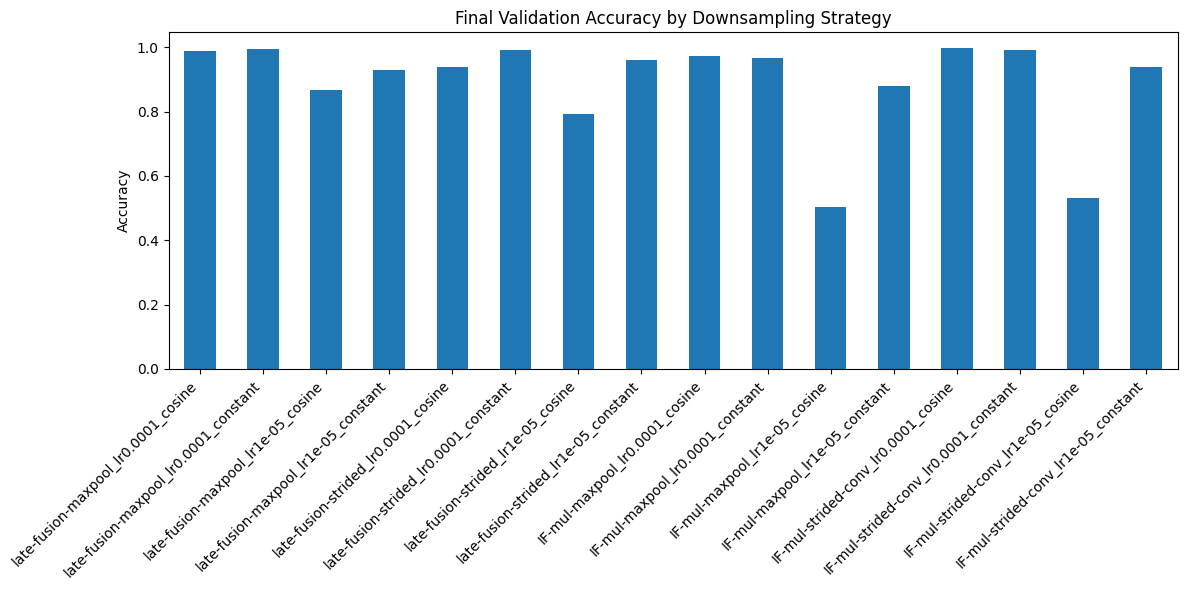

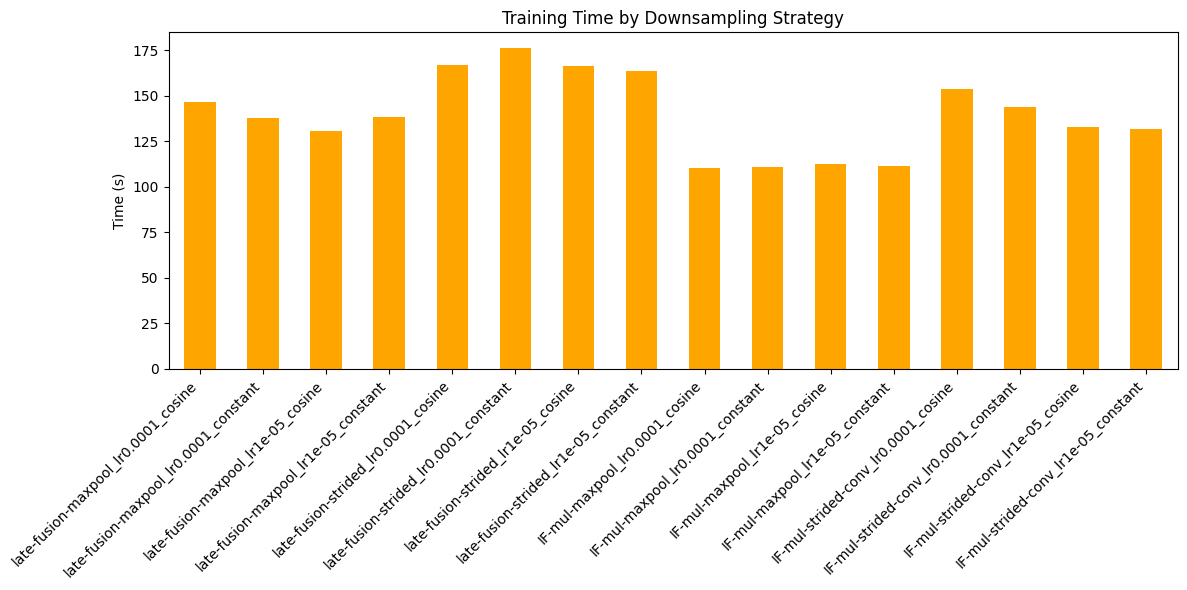

In [7]:
# Create Comparison Table
df_results = pd.DataFrame(results).T
print(df_results)

# Bar plot of Final Accuracy
plt.figure(figsize=(12, 6))
df_results['Final Accuracy'].plot(kind='bar')
plt.title('Final Validation Accuracy by Downsampling Strategy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Bar plot of Training Time
plt.figure(figsize=(12, 6))
df_results['Training Time (s)'].plot(kind='bar', color='orange')
plt.title('Training Time by Downsampling Strategy')
plt.ylabel('Time (s)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Analysis

#### Theoretical Thoughts
The **MaxPool** approach does not require any paramaters or complex algorithmics for computation. It simply takes the max. This makes is more lightweight in training and inference. However, since it always just takes the max, it is not very sophisticated and might miss important features.

The **StridedConv** approach replaces the ''stupid'' max pooling with learnable parameters which can lead to better feature extraction. However, this comes at the cost of having more parameters, making the model larger and more expensive to run and train. If that is worth the cost depends on the actual performance difference.

#### Practical Results
##### Full Embedders in Late Fusion Model
| Metric         | MaxPool | Strided Conv | Difference |
|----------------|---------|--------------|-----------------------|
| Val Loss       | 0.021708| 0.025732     | 0,004024             |
| Parameters     | 13,147,202| 13,383,802 | 236.600              |
| Training Time  | 137.9 sec| 175.9 sec   | 20                   |
| Final Accuracy | 0.99375 | 0.990625     | -0.003125              |


##### Intermediate Fusion with Multiplication
| Metric         | MaxPool | Strided Conv | Difference |
|----------------|---------|--------------|-----------------------|
| Val Loss       |0.066811 |0.012317      | -0.054494            |
| Parameters     |6,615,952|6,852,552     | 236,600              |
| Training Time  |110.35 sec|153.58 sec   | 43,23                |
| Final Accuracy |0.971875 |0.996875      | 0,025                |

The performances are not really significantly different. Especially if we were to train on the full set, all models would end up very close to 100% Accuracy. The biggest difference is in parameter count and training time. However, the training times are to be taken with a grain of salt, since this training happend on my laptop, which is more inconsitent than a dedicated GPU.

For this task, the overhead of Strided Convolutions for downsampling does not provide a noticable improvement of the models' capabilities.